#### Quick look at the data

In [1]:
import numpy as np 
import matplotlib as mpl
import matplotlib.pyplot as plt
import xarray as xr
import geopandas
import gsw
import functions
import pandas as pd

In [2]:
plt.rc('font', size=12)

### Load in altimetry data

In [3]:
adt = functions.import_cmems('adt', 
      'https://my.cmems-du.eu/thredds/dodsC/cmems_obs-sl_glo_phy-ssh_my_allsat-l4-duacs-0.25deg_P1D', 
      'mjakes', 'ohw_22_MJ', -180, 180, -65, -45, '2019-01-01', '2019-03-01')

### Saildrone data

Circumpolar track around the Southern Ocean from 2019.

In [4]:
# TO DO: Load in ADCP data too and make some plots

In [5]:
ds_saildrone = xr.open_mfdataset("~/shared/antarctic_sd_data/saildrone-gen_5-antarctica_circumnavigation_2019-sd1020-20190119T040000-20190803T043000-1_minutes-v1.1620360815446.nc", chunks='auto')

In [6]:
# subset of variables from the dataset

variables = [
    'TEMP_CTD_RBR_STDDEV',
    'TEMP_CTD_RBR_MEAN',
    'SAL_RBR_MEAN',
    'SAL_RBR_STDDEV',
    'O2_CONC_AANDERAA_MEAN',
    'O2_CONC_AANDERAA_STDDEV',
    'CHLOR_RBR_MEAN',
    'CHLOR_RBR_STDDEV']

df = ds_saildrone[variables].to_dataframe() 
# How are these variables calculated? Mean/sstdev of the top few m??

df.index = df.index.droplevel(0) # getting rid of trajectory info

In [7]:
df = df.set_index('time', drop=False)

In [8]:
distance = functions.distFromStart(df.latitude.values, df.longitude.values)
df['distance_km'] = distance

In [9]:
mean_sea_level = adt.mean(dim = 'time')

In [10]:
adt_levels = np.arange(-1.5,1,0.25)

(-180.0, 180.0)

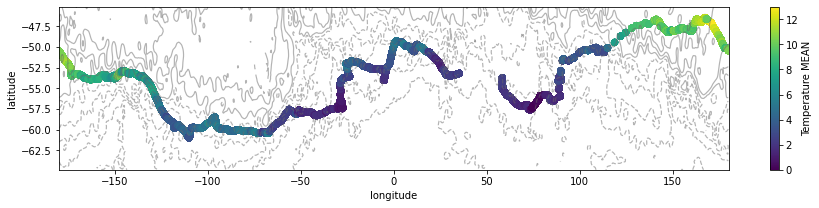

In [11]:
fig, ax = plt.subplots(figsize = (15,3))
plt.scatter(df.longitude, df.latitude, c = df.TEMP_CTD_RBR_MEAN, vmin = 0, vmax = 13)

CS = mean_sea_level.plot.contour(colors = 'dimgrey', alpha = 0.5, linewidths = 1.2, levels = adt_levels)
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.colorbar(label = 'Temperature MEAN')

plt.xlim(-180,180)

# TO DO: bin the ADT values into longitude (and time) bins so that the ADT contours on the map show the mean ADT during that part of the saildrone trajectory

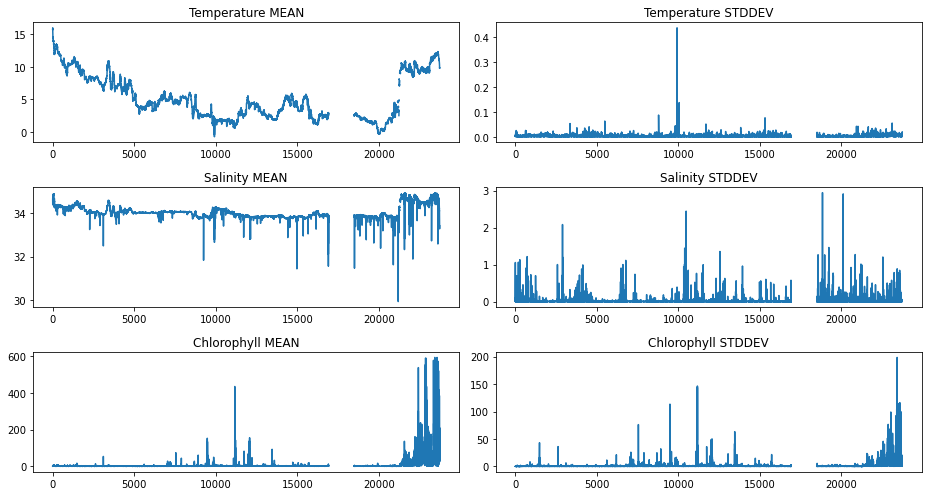

In [12]:
# Some timeseries plots to have a look at the data 
x = df.time
x = df.distance_km

fig, axs = plt.subplots(3, 2, figsize = (13,7))
axs = axs.flatten()

axs[0].plot(x, df.TEMP_CTD_RBR_MEAN)
axs[0].set_title('Temperature MEAN')

axs[1].plot(x, df.TEMP_CTD_RBR_STDDEV)
axs[1].set_title('Temperature STDDEV')

axs[2].plot(x, df.SAL_RBR_MEAN)
axs[2].set_title('Salinity MEAN')

axs[3].plot(x, df.SAL_RBR_STDDEV)
axs[3].set_title('Salinity STDDEV')

axs[4].plot(x, df.CHLOR_RBR_MEAN)
axs[4].set_title('Chlorophyll MEAN')

axs[5].plot(x, df.CHLOR_RBR_STDDEV)
axs[5].set_title('Chlorophyll STDDEV')

plt.tight_layout(h_pad = 1.2)

## Front detection

In [55]:
def detect_fronts(df, var, criterion, x = 'distance_km', x_bin = 20):
    
    df['dx'] = np.abs(np.gradient(df[x]))
    df['d_var'] = np.abs(np.gradient(df[var]))
    
    df_new = df[[var, 'latitude', 'longitude', x, 'dx', 'd_var']]
    
    # group into 20 km segments
    df_grouped = df_new.groupby(df_new[x] // x_bin)
    
    # apply minimum observations function
    # returns nan is there are < 10 observations else computes the mean of the group
    df_group_mean = df_grouped.apply(minimum_obs)
    
    # calculate gradient of var with distance
    df_group_mean['d_var_dx'] = np.round(df_group_mean['d_var'], 3)/df_group_mean['dx']
    
    # front detection criteria
    criterion = [-np.inf] + criterion + [np.inf]
    
    df_group_mean['level'] = pd.cut(df_group_mean['d_var_dx'], criterion, labels = False)
    
    return df_group_mean


In [80]:
def minimum_obs(group):
    if len(group) < 10:
        return np.nan
    else:
        return group.mean()

In [90]:
# input the data variable that you want to find fronts with
var = 'TEMP_CTD_RBR_MEAN'

# TO DO: Discuss what criterion we should use for different variables.
criterion = [0.01, 0.05, 0.25, 0.75, 1] 

temp_fronts = detect_fronts(df, var, criterion)

(-180.0, 180.0)

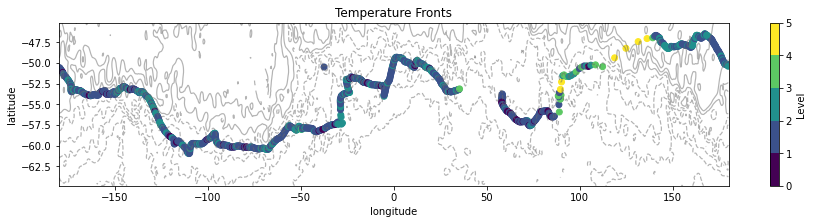

In [91]:
fig, ax = plt.subplots(figsize = (15,3))

cmap = plt.cm.viridis
norm = mpl.colors.BoundaryNorm(np.arange(0, len(criterion)+1, 1), cmap.N)

plt.scatter(fronts.longitude, fronts.latitude, c = fronts.level, norm = norm)

CS = mean_sea_level.plot.contour(colors = 'dimgrey', alpha = 0.5, linewidths = 1.2, levels = adt_levels)
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.colorbar(label = 'Level', ticks = np.arange(0, len(criterion)+1, 1))
plt.title('Temperature Fronts')
plt.xlim(-180,180)